# Welcome to Augmentoolkit

This notebook is where you generate all your data.

Augmentoolkit is meant to allow instruct-tuned models to learn from books, even using themselves to generate new data through a sort-of bootstrapping method. It is meant to stop model creators from having to work as data annotators, and not actual model trainers. It is meant to allow anyone to make their own high-quality dataset with thousands of entries.

## Quickstart:

- Get this notebook and the other repo code onto a machine with the power to run Airoboros-l2-70b-3.1.2.Q4_K_M
- Run all the cells below and watch as the notebook generates questions, answers, and conversations based on Principles of Chemistry, Simple Sabotage, and Introduction to Philosophy.

If you want to add your own texts, follow the instructions in list item #1 above.

### Note: this notebook makes roughly 1/3 characters generated to be **mildly NSFW** by default. You will need to modify the character personality code in `./generation_functions/special_instructions.py` or use "Assistant mode" if you want something cleaner.

## Customization:
### Here are some ways you can adapt this notebook to your use case, along with a brief description of how to do so, arranged in increasing order of difficulty (this information is also available in the README):
1. ***Change the source texts used to generate training data.*** You can do this in the cell right below this one. **IMPORTANT** the filenames of these should be formatted in a specific way, since the filenames are used as part of the prompts and in at least one regex. You need to have them be like: `[textname], by authorname`. You can also include the publication date after the author name if you want, but note that this will tend to bias most of the characters to live in the era of the textbook, which may or may not be what you want.

2. ***Change the personalities of the characters generated.*** Currently, when generating characters for the multiturn conversation step, three randomly-selected traits are appended to the "special instructions" set of the prompt to constrain what kind of character is generated by the model. Depending on what kind of model you want to make, or even just if your preferences vary, then you will probably want to modify this a bit. You can do so in `./generation_functions/special_instructions.py`. A more in-depth description of the trait-axis system that I (over)thought up is available in the comments of that file.

3. ***Change the constants.*** There are a few constant values in this notebook, and in `./generation_functions/constant_values.py`. These constants are tested, but if your use case requires special settings (e.g., you want to make conversations from more permutations of existing questions; or you think the character counts for the "duplicate question/answer" validation functions are too restrictive) then feel free to change the related setting. The most intuitive and least-likely-to-break-anything settings to change are rearrangements_to_take and double_check_counter. Beyond that... you'll need to figure out what the function does before changing it if you expect it to run.

4. ***Assistant Mode*** Technically this could be considered part of 3), but it's different enough that I feel it warrants separate explanation. By default, the notebook is configured to produce RP-style data; "Assistant mode" is something you can toggle in the settings cell immediately below this one, which skips character and scenario generation and answers every question in a chat between a user and a helpful AI assistant (with no personality). In the limited testing I have done with this, **it seems that assistant mode is simple enough to work with 13b models** such as Flatorcamaid by Ikari. So if your compute or time are very limited, or you are using this for a more professional use case, feel free to turn this on.

5. ***Change the model.*** This is as simple as switching the LOGICAL_MODEL value out for another one, but your mileage may vary significantly. My personal recommendation is to use [FlatOrcamaid](https://huggingface.co/TheBloke/FlatOrcamaid-13B-v0.2-GGUF/tree/main) (helluva name, I know) for the small model, and [Airoboros-l2-70b-3.1.2.Q4_K_M](https://huggingface.co/TheBloke/Airoboros-L2-70B-3.1.2-GGUF) for the large model. You need 12k context on your model, but Aphrodite Engine should handle the RoPE scaling automatically. Check `augmentoolkit/generation_functions/engine_wrapper.py` to customize the engine's parameters.

6. ***Change the examples.*** If you change the examples you can completely overhaul what this notebook does, but this requires a lot of prompting skill and possibly huge amounts of time to get it working again (source: most of my last three months were spent prompting, and most of this prompting was spent on the examples). Unless you want to convert this notebook from question-and-answer generation to some completely other task, I'd recommend changing only the conversation generation prompts -- they're a bit less finnicky, and if you just want to change the kind of characters generated (maybe you want a different writing style) that's where you'd find the differences.



## NOTE
You will want to turn off USE_SUBSET if you are doing a proper run over an entire text. It's on by default so you can iterate faster in the preparatory stages of dataset generation (and so that you can see the magic happen faster when you first use Augmentoolkit :) )

In [1]:
# NOTE NOTEBOOK SETTINGS AND CONSTANTS (some script file constants are in generation_functions/constants.py)

# Put your desired quant of your desired model in the relevant directories


# "airoboros-l2-70b-3.1.2.Q4_K_M.gguf" <- recommended for the large logical model
# "flatorcamaid-13b-v0.2.Q8_0.gguf" <- recommended for the normal logical model
# A6000s on Vast.ai are a good choice for running this notebook

LOGICAL_MODEL = "NousResearch/Nous-Hermes-2-Mixtral-8x7B-DPO"#"TheBloke/FlatOrcamaid-13B-v0.2-GPTQ"  # model used for decision-making and base question generation (should be "smart")

LARGE_LOGICAL_MODEL = "NousResearch/Nous-Hermes-2-Mixtral-8x7B-DPO"#"TheBloke/Airoboros-L2-70B-3.1.2-GPTQ"

ASSISTANT_MODE = False  # change to true if you want all conversations to be with an "AI language model" and not characters. Useful for more professional use cases.

DOUBLE_CHECK_COUNTER = 3  # Set to 1 to check outputs only once; set to 2 to check twice; set to 3 to check thrice, etc. Set to 0 to break everything in vet_question_loop() and elsewhere. Set to -1 and cause the universe to implode?

USE_SUBSET = True # Set to True if you want to use only a small subset of the text, to test whether it plays nicely with the current setup of the notebook

REARRANGEMENTS_TO_TAKE = 3  # How many of the possible permutations of tuples in a group to take and make multiturn convs out of. Adjust higher to get more data out of less text, but it might be a bit repetitive. NOTE your eval loss will be basically worthless if you aren't careful with how you shuffle your dataset when you're about to train.

USE_FILENAMES = False # Turn on if you want the model to use the names of your files as additional context (this is what original Augmentoolkit does). Useful if you have a small number of large input files grouped by subject matter, IE books. Turn off if you have a large number of files with meaningless names.

CONCURRENCY_LIMIT = 90  # Adjust this number based on the rate limit constraints of your api

source_texts = [
    "Simple Sabotage, by the Office of Strategic Services, published 1944.txt",
    "Principles of Chemistry, by Demitry Mendeleev, published 1897.txt",
]

## Below: Defines and imports functions that you will probably use no matter what cells in the notebook you choose to run:

In [2]:
import os
import uuid

# This is in no way best practices, but all my prompts being searchable and separate files is a good way to make my life easier.
import pkgutil
import importlib
import sys
from tqdm import asyncio as tqdmasyncio
import asyncio


# Set up rate-limit-conscious functions
semaphore = asyncio.Semaphore(CONCURRENCY_LIMIT)

async def run_task_with_limit(task):
    async with semaphore:
        # Run your task here
        return await task


# We have to define this up here so that two-step generation works, you'll see later.
multi_turn_convs_info_dir = "./multi_turn_convs_info"  # we generate all the information fed to the multiturn prompt, and generate the actual multiturn prompt, separately; since every step but the last is capable of being done by a 13b

sys.path.append("./generation_functions")
sys.path.append("./control_flow_functions")

import augmentoolkit.generation_functions as generation_functions  # This is the package directory
from augmentoolkit.control_flow_functions import control_flow_functions

# First, import all modules so they can be reloaded
for _, module_name, _ in pkgutil.iter_modules(
    generation_functions.__path__, generation_functions.__name__ + "."
):
    importlib.import_module(module_name)

# Now, reload each module and import all callable attributes
for _, module_name, _ in pkgutil.iter_modules(
    generation_functions.__path__, generation_functions.__name__ + "."
):
    # Reload the module
    module = importlib.reload(sys.modules[module_name])
    # Iterate through each attribute in the reloaded module
    for attribute_name in dir(module):
        # Retrieve the attribute
        attribute = getattr(module, attribute_name)
        if callable(attribute):
            # If it's callable, it's a function or class, so you set it in the globals dictionary
            globals()[attribute_name] = attribute

In [3]:
# Initialize API Client
engine_wrapper = EngineWrapper(model=LOGICAL_MODEL)

In [4]:
from transformers import AutoTokenizer
import re
from tqdm import tqdm
import nltk

nltk.download("punkt")
from nltk.tokenize import sent_tokenize

tokenizer = AutoTokenizer.from_pretrained(
    "Gryphe/MythoMax-L2-13b"
)  # It doesn't matter what model goes here, really

sentence_chunks = []
for source_text in source_texts:
    sentence_chunks += control_flow_functions.sentence_chunking_algorithm(source_text, tokenizer)

conversions = [("\n", " "), ("  ", " ")]

paragraphs_processed = [
    (control_flow_functions.fix_text(conversions, seq[0]), seq[1]) for seq in sentence_chunks
]

[nltk_data] Downloading package punkt to /Users/evan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Processing Simple Sabotage, by the Office of Strategic Services, published 1944.txt: 100%|██████████| 603/603 [00:00<00:00, 12843.23it/s]
Processing Principles of Chemistry, by Demitry Mendeleev, published 1897.txt: 100%|██████████| 13846/13846 [00:01<00:00, 9631.42it/s]


#### Inspect various features of the text you have fed in to see if it came out alright-ish

In [5]:
len(paragraphs_processed)

1925

In [6]:
paragraphs_processed[1]

('The instructions may be placed in separate pamphlets or leaflets according to categories of operations but should be distributed with care and not broadly. They should be used as a basis of radio broadcasts only for local and special cases and as directed by the theater commander. AR 380-5, pertaining to handling of secret documents, will be complied with in the handling of this Manual. [Illustration] William J. Donovan   CONTENTS  1. INTRODUCTION 2. POSSIBLE EFFECTS 3. MOTIVATING THE SABOTEUR 4. TOOLS, TARGETS, AND TIMING 5. SPECIFIC SUGGESTIONS FOR SIMPLE SABOTAGE   1. INTRODUCTION  The purpose of this paper is to characterize simple sabotage, to outline its possible effects, and to present suggestions for inciting and executing it. Sabotage varies from highly technical _coup de main_ acts that require detailed planning and the use of specially-trained operatives, to innumerable simple acts which the ordinary individual citizen-saboteur can perform. This paper is primarily concerne

#### The below cell will take a while to start generating for various screwy async reasons. It's doing its job, it just schedules everything first and THEN you see results.

In [7]:
import json
import os
from tqdm import tqdm
import asyncio

# Create directory if it doesn't exist
output_dir = "./worthy_for_questions"
os.makedirs(output_dir, exist_ok=True)

# Determine which paragraphs are worthy of making questions from
judged_worthy_for_questions = []

await control_flow_functions.filter_all_questions(paragraphs_processed, judged_worthy_for_questions, engine_wrapper, output_dir, take_subset=USE_SUBSET, use_filenames=True, rtwl=run_task_with_limit)

100%|██████████| 13/13 [00:00<00:00, 4637.35it/s]

LOADING:  {'paragraph': 'It also can be conveyed directly: statements praising the effectiveness of simple sabotage can be contrived which will be published by white radio, freedom stations, and the subversive press. Estimates of the proportion of the population engaged in sabotage can be disseminated. Instances of successful sabotage already are being broadcast by white radio and freedom stations, and this should be continued and expanded where compatible with security. (c) More important than (a) or (b) would be to create a situation in which the citizen-saboteur acquires a sense of responsibility and begins to educate others in simple sabotage. (2) _Encouraging Destructiveness_ It should be pointed out to the saboteur where the circumstances are suitable, that he is acting in self-defense against the enemy, or retaliating against the enemy for other acts of destruction. A reasonable amount of humor in the presentation of suggestions for simple sabotage will relax tensions of fear. (

/Users/evan/repos/augmentoolkit/augmentoolkit/control_flow_functions/control_flow_functions.py:514: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


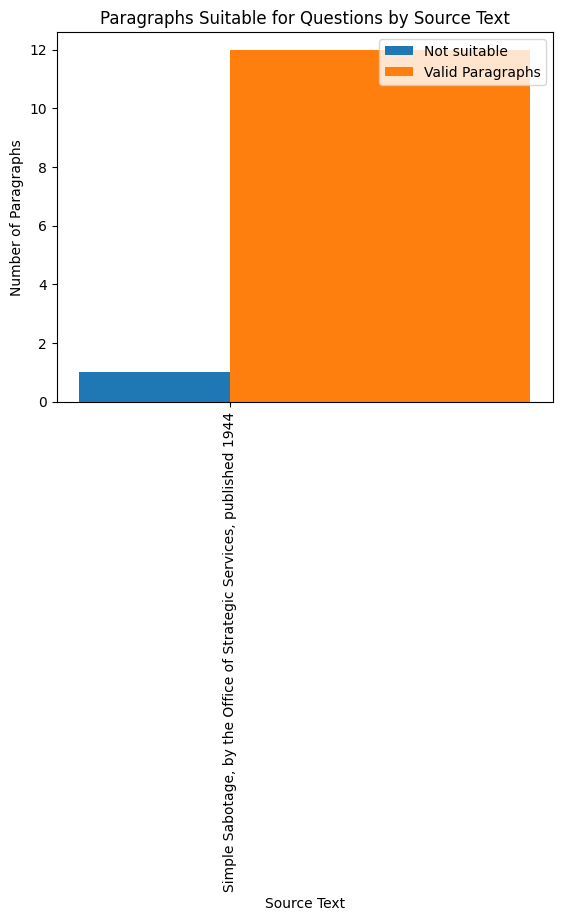

In [8]:
filtered_worthy_for_questions = control_flow_functions.filter_and_graph(judged_worthy_for_questions)

In [9]:
print(filtered_worthy_for_questions[0])

('It also can be conveyed directly: statements praising the effectiveness of simple sabotage can be contrived which will be published by white radio, freedom stations, and the subversive press. Estimates of the proportion of the population engaged in sabotage can be disseminated. Instances of successful sabotage already are being broadcast by white radio and freedom stations, and this should be continued and expanded where compatible with security. (c) More important than (a) or (b) would be to create a situation in which the citizen-saboteur acquires a sense of responsibility and begins to educate others in simple sabotage. (2) _Encouraging Destructiveness_ It should be pointed out to the saboteur where the circumstances are suitable, that he is acting in self-defense against the enemy, or retaliating against the enemy for other acts of destruction. A reasonable amount of humor in the presentation of suggestions for simple sabotage will relax tensions of fear. (a) The saboteur may hav

### The cell below begins generating questions. SOME OF THESE MAY FAIL and have to retry due to model errors (the API branch cannot use grammars). But if you let it run you will see that the vast majority eventually get through.

In short, don't get scared by tracebacks.

In [4]:
# control flow
import json
import os
import glob

# Directory for QA tuples
qa_tuples_dir = "./qatuples_raw"
if not os.path.exists(qa_tuples_dir):
    os.makedirs(qa_tuples_dir)

# Initialize vetted_qa_tuples
vetted_qa_tuples = []  # tuple list of qa tuples that have been judged good

# Attempt to initialize filtered_worthy_for_questions
try:
    _ = filtered_worthy_for_questions
except NameError:
    filtered_worthy_for_questions = []

if not filtered_worthy_for_questions:
    # Load all files in the qa_tuples_dir if filtered_worthy_for_questions is not initialized
    existing_files = glob.glob(os.path.join(qa_tuples_dir, "*.json"))
    for file_path in existing_files:
        with open(file_path, "r") as file:
            qa_tuple = tuple(json.load(file))
            print(f"Loaded {file}")
        vetted_qa_tuples.append(qa_tuple)
else:
    tasks = [control_flow_functions.generate_qatuples_from_para(
        idx,
        para,
        engine_wrapper=engine_wrapper,
        vetted_qa_tuples=vetted_qa_tuples,
        qa_tuples_dir=qa_tuples_dir,
        double_check_counter=DOUBLE_CHECK_COUNTER,
        use_filenames=USE_FILENAMES) for idx,para in enumerate(filtered_worthy_for_questions)]
    limited_tasks_qgen = [run_task_with_limit(task) for task in tasks]
    for future in tqdmasyncio.tqdm.as_completed(limited_tasks_qgen):
            await future
    

Loaded <_io.TextIOWrapper name='./qatuples_raw/para_4_q_0.json' mode='r' encoding='UTF-8'>
Loaded <_io.TextIOWrapper name='./qatuples_raw/para_4_q_1.json' mode='r' encoding='UTF-8'>


In [5]:
print(
    "-------------- QUESTIONS CREATED ------------- STATS SO FAR (may be wrong if run was continued from interruption):"
)
nones = list(filter(lambda x: x[0] is None, vetted_qa_tuples))
print(f"Nones: {len(nones)}")
print(f"Non-nones: {len(vetted_qa_tuples) - len(nones)}")
print(f"Total: {len(vetted_qa_tuples)}")
# filter out all None values
vetted_qa_tuples = [qa for qa in vetted_qa_tuples if qa[0] is not None]
print("---------------- ONTO EXAMPLES GENERATION-------------------")

-------------- QUESTIONS CREATED ------------- STATS SO FAR (may be wrong if run was continued from interruption):
Nones: 0
Non-nones: 2
Total: 2
---------------- ONTO EXAMPLES GENERATION-------------------


In [6]:
# Check for and fix the common mistake: mentioning "the text".
writepath = "./qatuples_revised"
import json

# Assuming vetted_qa_tuples is a list that might or might not exist
try:
    _ = vetted_qa_tuples
except NameError:
    vetted_qa_tuples = []

# Load all files at the start if vetted_qa_tuples is empty
if not vetted_qa_tuples:
    # Check if the directory exists
    if os.path.exists(writepath):
        # List all files in directory
        for file_name in os.listdir(writepath):
            file_path = os.path.join(writepath, file_name)
            try: # for each file already generated, see if it succeeded or failed; if it succeeded, append its contents; if it failed, append None for stats logging
                with open(file_path, "r", encoding="utf-8") as f:
                    content = f.read()
                    print(f"Loading file: {file_path}")
                    if content == "failed":
                        vetted_qa_tuples.append(None)
                    else:
                        try:
                            data = json.loads(content)
                            vetted_qa_tuples.append(
                                (data[0], data[1], data[2], data[3])
                            )
                        except json.JSONDecodeError:
                            print("JSON decode error with the contents:", content)
                            vetted_qa_tuples.append(None)
            except Exception as e:
                print(f"Error reading {file_path}: {e}")

else:
    old_tuples = vetted_qa_tuples.copy()
    tasks = [control_flow_functions.repair_qatuple_context(idx, tup, engine_wrapper, writepath, vetted_qa_tuples,use_filenames=USE_FILENAMES) for idx, tup in enumerate(vetted_qa_tuples)]
    limited_tasks_qcorrection = [run_task_with_limit(task) for task in tasks]
    for future in tqdmasyncio.tqdm.as_completed(limited_tasks_qcorrection): 
        await future

 50%|█████     | 1/2 [00:04<00:04,  4.56s/it]

Leaving be...
Output written to ./question_context_revision_generations/f4a9e1e8-8f05-4abc-9274-8783c4d853a5.txt


100%|██████████| 2/2 [00:09<00:00,  4.98s/it]

Rewording...
('How do the tips help the saboteur avoid detection and retaliation?', 'The tips provided in the text help the saboteur avoid detection and retaliation by using materials which appear innocent, committing acts for which large numbers of people could be responsible, and making excuses when necessary.', '(bIt should not be difficult to prepare leaflets and other media for the saboteur about the choice of weapons, time, and targets which will insure the saboteur against detection and retaliation. Among such suggestions might be the following: (1) Use materials which appear to be innocent. A knife or a nail file can be carried normally on your person; either is a multi-purpose instrument for creating damage. Matches, pebbles, hair, salt, nails, and dozens of other destructive agents can be carried or kept in your living quarters without exciting any suspicion whatever. If you are a worker in a particular trade or industry you can easily carry and keep such things as wrenches, 

In [7]:
# Print stats related to revised qatuples, and filter out nones (questions that were unanswerable due to lack of context).
import json
import os

print("-------------- QUESTIONS REVISED ------------- STATS SO FAR:")
nones = list(filter(lambda x: x is None, vetted_qa_tuples))
print(f"Nones: {len(nones)}")
print(f"Non-nones: {len(vetted_qa_tuples) - len(nones)}")
print(f"Total: {len(vetted_qa_tuples)}")
# filter out all None values
vetted_qa_tuples = [qa for qa in vetted_qa_tuples if qa is not None]
print("---------------- ONTO EXAMPLES GENERATION-------------------")

-------------- QUESTIONS REVISED ------------- STATS SO FAR:
Nones: 0
Non-nones: 2
Total: 2
---------------- ONTO EXAMPLES GENERATION-------------------


In [8]:
qa_tuples_by_paragraph = control_flow_functions.group_by_text(vetted_qa_tuples)

In [9]:
import os

if not os.path.exists(multi_turn_convs_info_dir):
    os.makedirs(multi_turn_convs_info_dir)

In [10]:
import json
import random
import itertools

multi_turn_convs_info = []


tasks = [control_flow_functions.create_info(idx,group,engine_wrapper, ASSISTANT_MODE, multi_turn_convs_info,multi_turn_convs_info_dir, REARRANGEMENTS_TO_TAKE,USE_FILENAMES) for idx,group in enumerate(qa_tuples_by_paragraph)]
limited_tasks_infocreation = [run_task_with_limit(task) for task in tasks]
for future in tqdmasyncio.tqdm.as_completed(limited_tasks_infocreation):
    await future

  0%|          | 0/1 [00:00<?, ?it/s]

Output written to ./multiturn_card_plan_generations/77148553-0b27-4183-b2b3-876bf536f943.txt
Output written to ./multiturn_card_generations/77148553-0b27-4183-b2b3-876bf536f943.txt
Extracted name: Violette Leclerc
Output written to ./multiturn_scenario_plan_generations/77148553-0b27-4183-b2b3-876bf536f943.txt
Extracted name: Violette Leclerc
Output written to ./multiturn_scenario_generations/77148553-0b27-4183-b2b3-876bf536f943.txt
Output written to ./multiturn_card_plan_generations/a9ce63e7-4b0c-454b-b1f5-38b0c59b17b6.txt
Output written to ./multiturn_card_generations/a9ce63e7-4b0c-454b-b1f5-38b0c59b17b6.txt
Extracted name: Prudence Pendleton
Output written to ./multiturn_scenario_plan_generations/a9ce63e7-4b0c-454b-b1f5-38b0c59b17b6.txt
Extracted name: Prudence Pendleton


100%|██████████| 1/1 [00:51<00:00, 51.80s/it]

Output written to ./multiturn_scenario_generations/a9ce63e7-4b0c-454b-b1f5-38b0c59b17b6.txt


### No notebook restart needed for API notebook!

In [11]:
import os
import json

convs_info = control_flow_functions.read_json_files_info(multi_turn_convs_info_dir)

In [12]:
import os
import json
import random
import itertools
import asyncio

multi_turn_convs_dir = "./multi_turn_convs"
if not os.path.exists(multi_turn_convs_dir):
    os.makedirs(multi_turn_convs_dir)

multi_turn_convs = []

tasks = [control_flow_functions.create_conversation(idx,info, engine_wrapper, multi_turn_convs, multi_turn_convs_dir, ASSISTANT_MODE) for idx,info in enumerate(convs_info)]
limited_tasks_convwriting = [run_task_with_limit(task) for task in tasks]
for future in tqdmasyncio.tqdm.as_completed(limited_tasks_convwriting):
    await future

  0%|          | 0/2 [00:00<?, ?it/s]

Extracted name: Violette Leclerc
--CONV STARTERS FILTERED--
['I', 'Welcome', 'Hey', "It's", 'Hello']


 50%|█████     | 1/2 [00:11<00:11, 11.56s/it]

Output written to ./multiturn_conversation_generations/77148553-0b27-4183-b2b3-876bf536f943.txt
Extracted name: Prudence Pendleton
--CONV STARTERS FILTERED--
['Oh', 'Welcome', 'Hey', "It's", 'Hello']
Output written to ./multiturn_conversation_generations/a9ce63e7-4b0c-454b-b1f5-38b0c59b17b6.txt
Answer 2: "Young man," Prudence sighs, shaking her head and looking away for a moment. "I have already answered your question, and I have no intention of repeating myself. I suggest you make the most of the information I have given you, and be on your way." does not match the corresponding answer in qatuples: The tips provided in the text help the saboteur avoid detection and retaliation by using materials which appear innocent, committing acts for which large numbers of people could be responsible, and making excuses when necessary., when necessary.
Answers in dialogues do not match corresponding answers in qatuples.
----------------



RETRYING!!!!



----------------
Extracted name: Prudence 

100%|██████████| 2/2 [00:28<00:00, 14.30s/it]

Output written to ./multiturn_conversation_generations/a9ce63e7-4b0c-454b-b1f5-38b0c59b17b6.txt


# Yay! Now you have a dataset!
### GPT wrote the cell below. I think it successfully converts things to ShareGPT format for use with axolotl, but I am not sure because I don't know that format very well and haven't used Axolotl. However, the json produced by the second function looks fine.

In [ ]:
import os
import json

# Make ShareGPT-format dataset (I think, still need verification it actually works)
control_flow_functions.convert_directory_to_list("./multi_turn_convs/")
# Make dataset in a format that has all the information. See README for details on this format.
control_flow_functions.convert_directory_and_process_conversations("./multi_turn_convs/")

Extracted name: Cynthia Davenport
Extracted name: Ilya Volkov
Extracted name: Bess Fletcher
Extracted name: Bella Anderson
Extracted name: Marek Zielinski
Extracted name: Clementine Mornay
Extracted name: Giselle Leclerc
Extracted name: Iris Turner
Extracted name: Uma Pendleton
Extracted name: Nora Davenport
Extracted name: Clementine Devereaux
Extracted name: Nora O'Brien
Extracted name: Cedric Pritchard
Extracted name: Nate Thompson
Extracted name: Lillian Banks
Extracted name: Fiona Morgan
Conversion complete. Master list written to 'master_list.json'. Simplified data written to 'simplified_data.json'.
Conversion complete. The processed master list is written to 'processed_master_list.json'.


In [ ]:
with open("./processed_master_list.json") as f:
    first = f.read()
    data = json.loads(first)

In [ ]:
# For curiosity's sake, you can find out how many lines of dialogue you generated
def filter_and_flatten(lst):
    # Initialize an empty list to hold the flattened elements
    flat_list = []

    # Loop through each sublist in the main list
    for sublst in lst:
        # Check if the first element of the sublist is itself a list (subsublist1)
        if isinstance(sublst[0], list):
            # Extend the flat_list with the elements from subsublist1
            flat_list.extend(sublst[0])

    return flat_list


len(filter_and_flatten(data))

89